In [17]:
import pandas as pd
import numpy as np

#a. Download the data

In [18]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train (1).csv


In [19]:
import io
df = pd.read_csv(io.BytesIO(uploaded['train.csv']))
df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [20]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (1).csv


In [21]:
import io
df_t = pd.read_csv(io.BytesIO(uploaded['test.csv']))
df_t.head(10)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


1) how many training and test data points are there? Training data has 7613 rows and test data has 3263 rows

In [22]:
#check number of records in training/testing data
print(len(df))
print(len(df_t))

7613
3263


2) What percentage of the training tweets are of real disasters, and what percentage is not? 43% of training tweets are real disasters

In [23]:
sum(df['target'] == 1)/ len(df['target'])

0.4296597924602653

In [24]:
df.groupby('target').apply(len)

target
0    4342
1    3271
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Disaster Distribution')

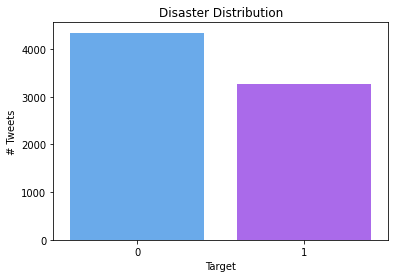

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure()
x = df.target.value_counts()
sns.barplot(x.index, x, palette='cool')
plt.gca().set_ylabel('# Tweets')
plt.gca().set_xlabel('Target')
plt.title("Disaster Distribution")

# b. Split the training data

In [26]:
from sklearn.model_selection import train_test_split

#Prepare X (with all remaining features) & y
X=df.drop(columns='target')
y=df['target']

#Split training data (70%) & validation data(30%)
X_train, X_val, Y_train, Y_val = train_test_split(X, y, 
    test_size=0.3, random_state= 8)

In [27]:
print(X_train.shape)
print(X_val.shape)

(5329, 4)
(2284, 4)


In [28]:
X.head()

,id,keyword,location,text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...


# c. Preprocess the data

1. Merge the data between train and test to make data preprocessing easier

In [29]:
df_train= df.drop("target",axis=1)
df_all= pd.concat([df_train,df_t], axis = 0, ignore_index= True)
df_all.head()

,id,keyword,location,text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...


In [30]:
len(df_all)

10876

In [31]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10876 entries, 0 to 10875
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        10876 non-null  int64 
 1   keyword   10789 non-null  object
 2   location  7238 non-null   object
 3   text      10876 non-null  object
dtypes: int64(1), object(3)
memory usage: 340.0+ KB


2. Removing url, html, emoji, number, and punctuation
Since text data usually contains unusual text, symbol, or link, we need to clean it so our model can make a prediction. Unhelpful character is considered a noise and can affect our model.

In [32]:
import re
import string

#function to removed URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

#function to removed emoji
def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#function to removed html
def remove_html(text):
    html = re.compile(
      r'^[^ ]<.*?>|&([a-z0-9]+|#[0-9]\"\'\“{1,6}|#x[0-9a-f]{1,6});[^A-Za-z0-9]+')
    return re.sub(html, '', text)

#function to removed punctuation
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

#function to removed quotes
def remove_quotes(text):
    quotes = re.compile(r'[^A-Za-z0-9\s]+')
    return re.sub(quotes, '', text)


#function to removed number
def remove_number(text):
  filtered_string = re.sub(r'\d+','', text)
  return filtered_string


#apply all above removal functions
df_all['removed_att_tex'] = df_all['text'].apply(lambda x: remove_URL(x))
df_all['removed_att_tex'] = df_all['removed_att_tex'].apply(lambda x: remove_emoji(x))
df_all['removed_att_tex'] = df_all['removed_att_tex'].apply(lambda x: remove_html(x))
df_all['removed_att_tex'] = df_all['removed_att_tex'].apply(lambda x: remove_punct(x))
df_all['removed_att_tex'] = df_all['removed_att_tex'].apply(lambda x: remove_quotes(x))
df_all['removed_att_tex'] = df_all['removed_att_tex'].apply(lambda x: remove_number(x))
df_all.head()

,id,keyword,location,text,removed_att_tex
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this earthquake Ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,All residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders in...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby Alaska as s...


3. Convert sentences into list of word

In [33]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
df_all['word_list'] = df_all['removed_att_tex'].apply(word_tokenize)
df_all.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,id,keyword,location,text,removed_att_tex,word_list
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders in...,"[people, receive, wildfires, evacuation, order..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala..."


4. Make lower sentences for all words

Standardizing sentences into lowercase for the sake of simplicity and consistency

In [34]:
df_all['lower_word'] = df_all['word_list'].apply(
    lambda x: [word.lower() for word in x]
)
df_all.head()

,id,keyword,location,text,removed_att_tex,word_list,lower_word
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders in...,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala..."


5. Removing stopword ("a", "the", "in", "because", "be", etc)

Stopwords are one of the most essential thing to do for preprocessing text data. Stopwords are common words in English. If we don't remove the stopwords, the words might be identified as important word in making prediction and affect our model accuracy.

In [35]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words= set(stopwords.words('english'))
df_all['remove_stopwords'] = df_all['lower_word'].apply(
    lambda x: [word for word in x if word not in stop_words])
df_all.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,id,keyword,location,text,removed_att_tex,word_list,lower_word,remove_stopwords
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders in...,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


6. Lemmatize by reducing words (affixes, suffixes, or prefixes) to roots of word. E.g: Sung to Sing, Easily to Easy

Lemmatize is important to avoid unnecessary information to our data that can create redundancy. E.g: "I love to eat" and "I love eating" has the same meaning, but without lemmatize, "eat" and "eating" will be considered a different word.

In [36]:
from nltk.stem import WordNetLemmatizer 
import nltk 
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
from nltk.corpus import wordnet

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

wnl = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [37]:
df_all['pos_tags'] = df_all['remove_stopwords'].apply(nltk.tag.pos_tag)

df_all['tag_word'] = df_all['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

df_all['lemma_words'] = df_all['tag_word'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

#remove stop words again after lemmatization
df_all['lemma_words'] = df_all['lemma_words'].apply(
    lambda x: [word for word in x if word not in stop_words])

df_all['lemma_str'] = [' '.join(map(str, l)) for l in df_all['lemma_words']]
df_all.head()

,id,keyword,location,text,removed_att_tex,word_list,lower_word,remove_stopwords,pos_tags,tag_word,lemma_words,lemma_str
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),...","[(deeds, n), (reason, n), (earthquake, n), (ma...","[deed, reason, earthquake, may, allah, forgive...",deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J...","[(forest, a), (fire, n), (near, n), (la, a), (...","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)...","[(residents, n), (asked, v), (shelter, a), (pl...","[resident, ask, shelter, place, notify, office...",resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders in...,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order...","[(people, NNS), (receive, VBP), (wildfires, NN...","[(people, n), (receive, v), (wildfires, n), (e...","[people, receive, wildfire, evacuation, order,...",people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N...","[(got, v), (sent, a), (photo, n), (ruby, n), (...","[get, sent, photo, ruby, alaska, smoke, wildfi...",get sent photo ruby alaska smoke wildfires pou...


Breaking df to train, holdout, and test data as original source

In [38]:
clean_train = pd.merge(X_train, df_all, on='id')
clean_val = pd.merge(X_val, df_all, on='id')
clean_test= pd.merge(df_t, df_all, on='id')

In [39]:
clean_train.head()

,id,keyword_x,location_x,text_x,keyword_y,location_y,text_y,removed_att_tex,word_list,lower_word,remove_stopwords,pos_tags,tag_word,lemma_words,lemma_str
0,6959,massacre,Colorado,Colorado movie massacre trial jurors reach ver...,massacre,Colorado,Colorado movie massacre trial jurors reach ver...,Colorado movie massacre trial jurors reach ver...,"[Colorado, movie, massacre, trial, jurors, rea...","[colorado, movie, massacre, trial, jurors, rea...","[colorado, movie, massacre, trial, jurors, rea...","[(colorado, NN), (movie, NN), (massacre, NN), ...","[(colorado, n), (movie, n), (massacre, n), (tr...","[colorado, movie, massacre, trial, juror, reac...",colorado movie massacre trial juror reach verd...
1,8029,refugees,NaN,Short of throwing them overboard himself I don...,refugees,NaN,Short of throwing them overboard himself I don...,Short of throwing them overboard himself I don...,"[Short, of, throwing, them, overboard, himself...","[short, of, throwing, them, overboard, himself...","[short, throwing, overboard, dont, think, lead...","[(short, JJ), (throwing, VBG), (overboard, JJ)...","[(short, a), (throwing, v), (overboard, a), (d...","[short, throw, overboard, dont, think, leader,...",short throw overboard dont think leader could ...
2,3130,debris,NaN,Debris found on Reunion Island comes from MH37...,debris,NaN,Debris found on Reunion Island comes from MH37...,Debris found on Reunion Island comes from MH M...,"[Debris, found, on, Reunion, Island, comes, fr...","[debris, found, on, reunion, island, comes, fr...","[debris, found, reunion, island, comes, mh, ma...","[(debris, NN), (found, VBD), (reunion, NN), (i...","[(debris, n), (found, v), (reunion, n), (islan...","[debris, find, reunion, island, come, mh, mala...",debris find reunion island come mh malaysian pm
3,10770,wreckage,iTunes,#science Now that a piece of wreckage from fli...,wreckage,iTunes,#science Now that a piece of wreckage from fli...,science Now that a piece of wreckage from flig...,"[science, Now, that, a, piece, of, wreckage, f...","[science, now, that, a, piece, of, wreckage, f...","[science, piece, wreckage, flight, mh, confirm...","[(science, NN), (piece, NN), (wreckage, NN), (...","[(science, n), (piece, n), (wreckage, n), (fli...","[science, piece, wreckage, flight, mh, confirm...",science piece wreckage flight mh confirm runio...
4,2379,collapsed,USA,Petition | Heartless owner that whipped horse ...,collapsed,USA,Petition | Heartless owner that whipped horse ...,Petition Heartless owner that whipped horse u...,"[Petition, Heartless, owner, that, whipped, ho...","[petition, heartless, owner, that, whipped, ho...","[petition, heartless, owner, whipped, horse, c...","[(petition, NN), (heartless, NN), (owner, NN),...","[(petition, n), (heartless, n), (owner, n), (w...","[petition, heartless, owner, whip, horse, coll...",petition heartless owner whip horse collapse t...


#d. Bag of Words Model

When we use min_df=10 (only including words that appear in at least 10 tweets), there are 988 number of features in bag-of-words from training data (including train and development set)

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(binary=True, min_df=10)
X = vectorizer.fit_transform(clean_train['lemma_str'])
train_vector = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
train_vector.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aba,abc,ablaze,absolutely,accident,across,act,action,actually,add,...,yearold,yes,yet,york,youll,youre,youth,youtube,yr,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Bag-of-words matrix in development set

In [41]:
X_val2 = vectorizer.transform(clean_val['lemma_str'])
val_vector = pd.DataFrame(X_val2.toarray(),
                          columns=vectorizer.get_feature_names())
val_vector.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aba,abc,ablaze,absolutely,accident,across,act,action,actually,add,...,yearold,yes,yet,york,youll,youre,youth,youtube,yr,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Visualize "Disaster" vs "Non-Disaster" word

In [42]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
temp = pd.merge(df, df_all, on='id')
temp.head()

,id,keyword_x,location_x,text_x,target,keyword_y,location_y,text_y,removed_att_tex,word_list,lower_word,remove_stopwords,pos_tags,tag_word,lemma_words,lemma_str
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),...","[(deeds, n), (reason, n), (earthquake, n), (ma...","[deed, reason, earthquake, may, allah, forgive...",deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,NaN,NaN,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J...","[(forest, a), (fire, n), (near, n), (la, a), (...","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,NaN,NaN,All residents asked to 'shelter in place' are ...,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)...","[(residents, n), (asked, v), (shelter, a), (pl...","[resident, ask, shelter, place, notify, office...",resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,NaN,NaN,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders in...,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order...","[(people, NNS), (receive, VBP), (wildfires, NN...","[(people, n), (receive, v), (wildfires, n), (e...","[people, receive, wildfire, evacuation, order,...",people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N...","[(got, v), (sent, a), (photo, n), (ruby, n), (...","[get, sent, photo, ruby, alaska, smoke, wildfi...",get sent photo ruby alaska smoke wildfires pou...


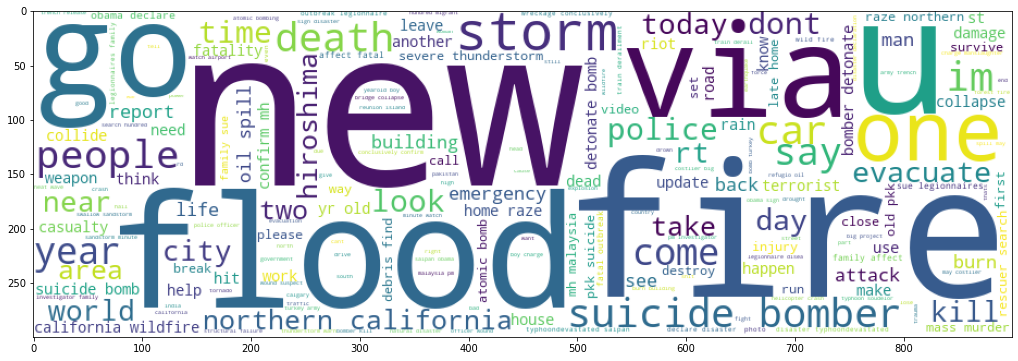

In [43]:
#Words in "Disaster" tweet
rt =temp['lemma_str'][temp['target'] == 1]
plt.subplots(figsize=(18,6))
wordcloud = WordCloud(background_color='white',
                      width=900,
                      height=300
                     ).generate(" ".join(rt))
plt.imshow(wordcloud)
plt.show()

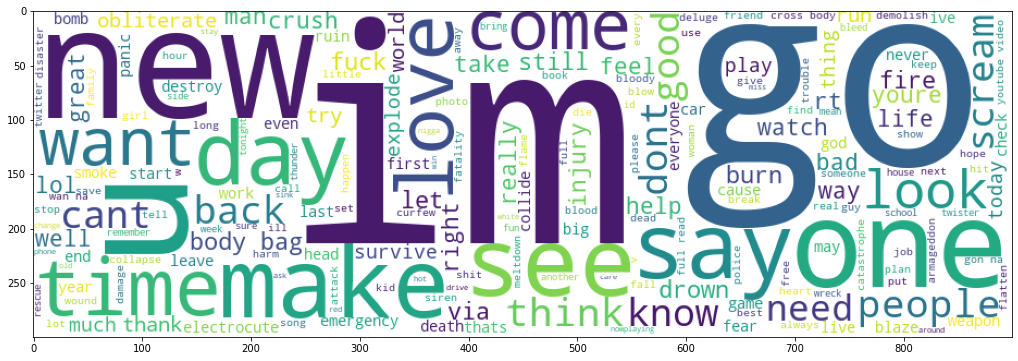

In [44]:
#Words in "Non-Disaster" tweet
rt =temp['lemma_str'][temp['target'] == 0]
plt.subplots(figsize=(18,6))
wordcloud = WordCloud(background_color='white',
                      width=900,
                      height=300
                     ).generate(" ".join(rt))
plt.imshow(wordcloud)
plt.show()

#e. Logistic Regression


i. Train logistic regression model without regularization term

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score

lr = LogisticRegression(penalty='none', C=1e5, random_state=1, 
                        solver='lbfgs', multi_class='ovr')
lr.fit(train_vector, Y_train)
Y_predict = lr.predict(val_vector)
Y_predict_train = lr.predict(train_vector)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [46]:
#With holdout data
print(metrics.accuracy_score(Y_val, Y_predict))
print(f1_score(Y_val, Y_predict))
#With train data themselves
print(metrics.accuracy_score(Y_train, Y_predict_train))
print(f1_score(Y_train, Y_predict_train))

0.7648861646234676
0.7210389610389609
0.8693938825295553
0.8418900499772831


ii. Train logistic regression model with L1 regularization

In [47]:
lr_l1 = LogisticRegression(penalty='l1', C=1, random_state=1, 
                           solver='liblinear', multi_class='ovr')
lr_l1.fit(train_vector, Y_train)
Y_predict_l1 = lr_l1.predict(val_vector)
Y_predict_l1_train = lr_l1.predict(train_vector)

In [48]:
#With holdout data
print(metrics.accuracy_score(Y_val, Y_predict_l1))
print(f1_score(Y_val, Y_predict_l1))
#With train data themselves
print(metrics.accuracy_score(Y_train, Y_predict_l1_train))
print(f1_score(Y_train, Y_predict_l1_train))

0.7753940455341506
0.7216494845360825
0.8495027209607806
0.8107597923548843


iii. Train logistic regression model with L2 regularization

In [49]:
lr_l2 = LogisticRegression(penalty='l2', C=0.1, random_state=1, 
                           solver='liblinear', multi_class='ovr')
lr_l2.fit(train_vector, Y_train)
Y_predict_l2 = lr_l2.predict(val_vector)
Y_predict_l2_train = lr_l2.predict(train_vector)

In [50]:
#With holdout data
print(metrics.accuracy_score(Y_val, Y_predict_l2))
print(f1_score(Y_val, Y_predict_l2))
#With train data themselves
print(metrics.accuracy_score(Y_train, Y_predict_l2_train))
print(f1_score(Y_train, Y_predict_l2_train))

0.7802101576182137
0.708139534883721
0.8226684180896979
0.7654504839910649


iv. Which one of the three classifiers performed the best on your training and development set? Did you observe any overfitting and did regularization help reduce it? Support your answers with the classifier performance you got. 

Overfitting happened when we used LogisticRegression without Regularization. One of the indicators that we can look at is huge gap in accuracy between prediction performed for training data and development set. When we predicted to train data, we got F1 score of 0.84 however when we predicted it to holdout data, our F1 score significantly dropped to 0.72, showing there's an overfitting to our train data. 

When we predicted the model using regularization, it added penalty to the parameters and help to reduce overfit. As we can see from L1 regularization result with hyperparameter c=1, F1 score in training data was 0.81 and F1 score in holdout was 0.72. Additionally, L2 regularization with hyperparameter c=0.1 gave us the best result to reduce overfitting where F1 score in training data was 0.77 and F1 score in holdout was 0.71

v. Inspect the weight vector of the classifier with L1 regularization (in other words, look at the θ you got after training). You can access the weight vector of the trained model using the coef_ attribute of a LogisticRegression instance. What are the most important words
for deciding whether a tweet is about a real disaster or not?

"Earthquake" is the most important words for deciding a tweet as a real disaster

In [51]:
a=lr_l1.coef_
print(a.shape)

(1, 988)


In [52]:
print(a.max())
result = np.where(a == np.amax(a))
print(result)

3.7218069177347264
(array([0]), array([268]))


In [53]:
train_vector.columns[268]

'earthquake'

#f. Bernoulli Naive Bayes
Implement the classifier similar to what was shown in class, without using any existing machine learning libraries such as sklearn. Only use basic libraries such as numpy.

In [54]:
#Checking holdout data performance using sklearn BernoulliNB
from sklearn.naive_bayes import BernoulliNB 
from sklearn.metrics import accuracy_score
clf = BernoulliNB()
model = clf.fit(train_vector, Y_train)
y_pred =clf.predict(val_vector)
acc_score = metrics.accuracy_score(Y_val, y_pred)
print(acc_score)

0.7793345008756567


In [55]:
n = train_vector.shape[0] # size of the dataset
d = train_vector.shape[1] # number of words/ features
K = 2 # number of class (disaster or not)

# these are the shapes of the parameters
psis = np.zeros([K,d])
phis = np.zeros([K])

In [56]:
#Compute maximum likelihood model parameters
for k in range(K):
      X_k = train_vector[Y_train.values == k]
      psis[k] = np.mean(X_k, axis=0)
      phis[k] = (X_k.shape[0]+1) / (float(n)+2)
print(phis)
print(psis)

[0.57268805 0.42731195]
[[0.00262123 0.00032765 0.00360419 ... 0.01703801 0.00098296 0.00458716]
 [0.0017567  0.00966184 0.00307422 ... 0.00746596 0.01185771 0.00307422]]


In [57]:
print(phis.shape)
print(psis.shape)
print(train_vector.shape)

(2,)
(2, 988)
(5329, 988)


In [58]:
#Check reshape
a= np.reshape(train_vector.values, (1,5329,988))
a

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])

In [59]:
def nb_predictions(x, psis, phis):
    """This returns class assignments and scores under the NB model.
    
    We compute \arg\max_y p(y|x) as \arg\max_y p(x|y)p(y)
    """
    # adjust shapes
    n, d = x.shape
    x = np.reshape(x.values, (1, n, d))
    psis = np.reshape(psis, (K, 1, d))
    
    # clip probabilities to avoid log(0)
    psis = psis.clip(1e-14, 1-1e-14)
    
    # compute log-probabilities
    logpy = np.log(phis).reshape([K,1])
    logpxy = x * np.log(psis) + (1-x) * np.log(1-psis)
    logpyx = logpxy.sum(axis=2) + logpy

    return logpyx.argmax(axis=0).flatten(), logpyx.reshape([K,n])

In [60]:
#Predict with train data
idx, logpyx = nb_predictions(train_vector, psis, phis)
print(idx[:10])
print(accuracy_score(Y_train, idx))
print(f1_score(Y_train, idx))

[1 0 1 1 0 1 1 0 1 0]
0.8187277162694689
0.7690100430416068


In [61]:
#Predict with holdout data
idx_val, logpyx = nb_predictions(val_vector, psis, phis)
print(accuracy_score(Y_val, idx_val))
print(f1_score(Y_val, idx_val))

0.7797723292469352
0.7204002223457476


#g. Model Comparison

1. Which model performed the best in predicting? Include your performance metric in your response. Comment on the pros and cons
of using generative vs discriminative models.

Both model don't give significant difference on prediction. However in this case, Naive Bayes gives a higher F1 score with 0.77 for train data and 0.72 for holdout data. While logistic regression with L2 regularization only gave us F1 score of 0.77 for train data and 0.71 for holdout data. The pros in using discriminative models (Logistic Regression) is we don't have to have assumption of independence in each variable, in which for text classification case, intuitively there must be some words with high correlation. In the case where variables have high correlation, discriminative model is often better than generative. On the other hand, using generative models (Naive Bayes) will give us a faster computation as the probabilities are directly computed. Additionally, in Naive Bayes, we can encouter zero probability when we have words in test data that are not available in train data and might end up with zero class probability.

2. Think about the assumptions that Naive Bayes makes. How are the assumptions different from logistic regressions? Discuss whether it’s valid and efficient to use Bernoulli Naive Bayes classifier for natural language texts.

Naive Bayes has assumption where all features are independent with each other while in reality it's not. For example, "Flood" and "Water" might have high correlation but Naive Bayes will assume they are independent. For natural language texts, if there are a lot of words that are not independent, using Naive Bayes will reduce number of parameters significantly. If the assumption hold given the actual data, we can prefer to use Naive Bayes, but otherwise we can prefer Logistic Regression 

#h. N-gram model

1. Using N =2, construct feature representations of the tweets in the training and development set
2. How you chose the threshold M, and report the total number of 1-grams and 2-grams in your vocabulary. Take 10 2-grams from your vocabulary, and print them out.

Construct 2-gram bag of ward matrix
- We choose the threshold min_df=10 because 1) this threshold worked pretty well in the previous 1-gram Bag of words model; 2) with this threshold, we will construct 1213 features, which is will below the size of our training data, and also avoid run-time and memory issues.
- With same threshold, we can easily calculate the # of 1-grams is 988 and the # of 2-grams is 1213-988 = 225.

In [62]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer2Gr = CountVectorizer(binary=True, min_df=10, ngram_range=(1,2))
X2Gr = vectorizer2Gr.fit_transform(clean_train['lemma_str'])
train_vector2Gr = pd.DataFrame(X2Gr.toarray(),columns=vectorizer2Gr.get_feature_names())
train_vector2Gr.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aba,aba woman,abc,abc news,ablaze,absolutely,accident,across,act,action,...,york,youll,youre,youth,youtube,youtube playlist,youtube video,yr,yr old,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
#Apply the same vectorizer to development set
X_val2Gr = vectorizer2Gr.transform(clean_val['lemma_str'])
val_vector2Gr = pd.DataFrame(X_val2Gr.toarray(),
                          columns=vectorizer2Gr.get_feature_names())
val_vector2Gr.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aba,aba woman,abc,abc news,ablaze,absolutely,accident,across,act,action,...,york,youll,youre,youth,youtube,youtube playlist,youtube video,yr,yr old,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
#10 examples of 2-grams
vectorizer2Gronly = CountVectorizer(binary=True, min_df=10, ngram_range=(2,2))
X2Gronly = vectorizer2Gronly.fit_transform(clean_train['lemma_str'])
list2Gr = pd.DataFrame(vectorizer2Gronly.get_feature_names())
print(list2Gr[0:10])

                         0
0                aba woman
1                 abc news
2                add video
3             affect fatal
4            air ambulance
5          aircraft debris
6        airplane accident
7              airport get
8              amid crisis
9  anniversary devastation


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


3. Implement a logistic regression and a Bernoulli classifier to train on 2-grams. Reuse the code in (e) and (f ) and choose to use or not use a regularization term, depending on what you got from (e)

Based on observations from part (e), L2 regularization can effectively reduce the overfitting effect, therefore we will implement a logistic regression with L2 regularization for the 2-Gram model.

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score

lr_2Gr = LogisticRegression(penalty='l2', C=0.1, random_state=1, 
                           solver='liblinear', multi_class='ovr')
lr_2Gr.fit(train_vector2Gr, Y_train)
Y_predict_2Gr = lr_2Gr.predict(val_vector2Gr)
Y_predict_2Gr_train = lr_2Gr.predict(train_vector2Gr)

In [66]:
#With holdout data
print(metrics.accuracy_score(Y_val, Y_predict_2Gr))
print(f1_score(Y_val, Y_predict_2Gr))
#With train data themselves
print(metrics.accuracy_score(Y_train, Y_predict_2Gr_train))
print(f1_score(Y_train, Y_predict_2Gr_train))

0.7780210157618214
0.7022900763358779
0.8236066804278477
0.7659362549800796


Implement Bernoulli Classifier

In [67]:
n = train_vector2Gr.shape[0] # size of the dataset
d2 = train_vector2Gr.shape[1] # number of words/ features
K = 2 # number of class (disaster or not)

# these are the shapes of the parameters
psis2 = np.zeros([K,d2])
phis2 = np.zeros([K])

In [68]:
#Compute maximum likelihood model parameters
for k in range(K):
      X_k2 = train_vector2Gr[Y_train.values == k]
      psis2[k] = np.mean(X_k2, axis=0)
      phis2[k] = X_k2.shape[0] / float(n)
print(phis2)
print(psis2)

[0.57271533 0.42728467]
[[0.00262123 0.00262123 0.00032765 ... 0.00098296 0.00032765 0.00458716]
 [0.0017567  0.00131752 0.00966184 ... 0.01185771 0.01097936 0.00307422]]


In [69]:
#Predict with train data
idx2, logpyx2 = nb_predictions(train_vector2Gr, psis2, phis2)
print(idx2[:10])
print(accuracy_score(Y_train, idx2))
print(f1_score(Y_train, idx2))

[1 0 1 1 0 1 1 0 1 0]
0.8166635391255395
0.7549535991973916


In [70]:
#Predict with Validation data
idx_val2, logpyx_val2 = nb_predictions(val_vector2Gr, psis2, phis2)
print(accuracy_score(Y_val, idx_val2))
print(f1_score(Y_val, idx_val2))


0.7819614711033275
0.710128055878929


4. Do these results differ significantly from those using the bag of words model?


The results from 2-gram model do not differ significantly from bag of words model:
- With logistic regression, the validation F1 is 0.7023 for 2-gram comparing to 0.7081 for 1-gram; with Bernoulli Classifier, the validation F1 is 0.7101 for 2-gram comparing to 0.7204 for 1-gram.
- It implies that for this specific case, using 1-gram bag of words model is sufficient to identify key words, because these words themselves already reflect key information/meaning of the "disasters", e.g. "earthquake", "fire", etc. and how people phrase the sentences and how are these words ordered/structured plays minor role in this case.

#i. Predict test set and submit to Kaggle using all training data

Re-build your feature vectors and re-train your preferred classifier (we choose bag of words and bernoulli classifier as our model) using the entire Kaggle training data.

In [71]:
clean_X = pd.merge(df.drop(columns='target'), df_all, on='id')
clean_X

,id,keyword_x,location_x,text_x,keyword_y,location_y,text_y,removed_att_tex,word_list,lower_word,remove_stopwords,pos_tags,tag_word,lemma_words,lemma_str
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),...","[(deeds, n), (reason, n), (earthquake, n), (ma...","[deed, reason, earthquake, may, allah, forgive...",deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,NaN,NaN,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J...","[(forest, a), (fire, n), (near, n), (la, a), (...","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,NaN,NaN,All residents asked to 'shelter in place' are ...,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)...","[(residents, n), (asked, v), (shelter, a), (pl...","[resident, ask, shelter, place, notify, office...",resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",NaN,NaN,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders in...,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order...","[(people, NNS), (receive, VBP), (wildfires, NN...","[(people, n), (receive, v), (wildfires, n), (e...","[people, receive, wildfire, evacuation, order,...",people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N...","[(got, v), (sent, a), (photo, n), (ruby, n), (...","[get, sent, photo, ruby, alaska, smoke, wildfi...",get sent photo ruby alaska smoke wildfires pou...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,NaN,NaN,Two giant cranes holding a bridge collapse int...,Two giant cranes holding a bridge collapse int...,"[Two, giant, cranes, holding, a, bridge, colla...","[two, giant, cranes, holding, a, bridge, colla...","[two, giant, cranes, holding, bridge, collapse...","[(two, CD), (giant, JJ), (cranes, NNS), (holdi...","[(two, n), (giant, a), (cranes, n), (holding, ...","[two, giant, crane, hold, bridge, collapse, ne...",two giant crane hold bridge collapse nearby home
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,ariaahrary TheTawniest The out of control wild...,"[ariaahrary, TheTawniest, The, out, of, contro...","[ariaahrary, thetawniest, the, out, of, contro...","[ariaahrary, thetawniest, control, wild, fires...","[(ariaahrary, JJ), (thetawniest, JJS), (contro...","[(ariaahrary, a), (thetawniest, a), (control, ...","[ariaahrary, thetawniest, control, wild, fire,...",ariaahrary thetawniest control wild fire calif...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano

In [72]:
X_final = vectorizer.fit_transform(clean_X['lemma_str'])
final_vector = pd.DataFrame(X_final.toarray(),columns=vectorizer.get_feature_names())
final_vector.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aba,abandon,abc,ablaze,able,absolutely,accident,accord,account,across,...,york,youll,young,youre,youth,youtube,youve,yr,yyc,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
n_f = final_vector.shape[0] # size of the dataset
d_f = final_vector.shape[1] # number of words/ features
K = 2 # number of class (disaster or not)

# these are the shapes of the parameters
psis_f = np.zeros([K,d_f])
phis_f = np.zeros([K])

In [74]:
#Compute maximum likelihood model parameters
for k in range(K):
      X_k_f = final_vector[y.values == k]
      psis_f[k] = np.mean(X_k_f, axis=0)
      phis_f[k] = X_k_f.shape[0] / float(n_f)
print(phis_f)
print(psis_f)

[0.57034021 0.42965979]
[[0.00207278 0.00115154 0.00023031 ... 0.00115154 0.         0.0052971 ]
 [0.00152858 0.00275145 0.00825436 ... 0.01008866 0.00305717 0.00275145]]


In [75]:
#transform test data
X_test = vectorizer.transform(clean_test['lemma_str'])
test_vector = pd.DataFrame(X_test.toarray(),
                          columns=vectorizer.get_feature_names())
test_vector.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aba,abandon,abc,ablaze,able,absolutely,accident,accord,account,across,...,york,youll,young,youre,youth,youtube,youve,yr,yyc,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
#Predict on the test data
idx_test, logpyx_test = nb_predictions(test_vector, psis_f, phis_f)
idx_test

array([1, 0, 1, ..., 1, 1, 0])

In [77]:
output = pd.DataFrame({'id':clean_test['id'].values,'target': idx_test},
                      columns=['id','target'])

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
output.to_csv('/drive/My Drive/disastertweet.csv',index=False)